* Autor - Bruno Augusto Souza Oliveira

* e-mail - bruno.augusto.souza@outlook.com

* Linkedin - https://www.linkedin.com/in/brunoaugustosouza/

# Resumo

Iremos construir uma estratégia utilizando o modelo de fronteira eficiente criado por Harry Markowitz.  Este modelo nos permite analisar um portfólio de investimentos com base no risco e retorno da carteira, por meio dele, podemos combinar diferentes pesos para cada ativo, gerando diferentes portfólios e buscando, sempre que possível, maximizar nosso retorno enquanto minimizamos o risco. Faremos uma breve introdução da teoria do modelo e também do movimento Browniano geométrico, o qual será usado na nossa estratégia.

# Teoria - Fronteira Eficiente

Resumidamente, no modelo de Markowitz queremos maximizar uma função que envolve métricas de risco e de retorno. Definiremos o retorno de um portfólio com n ativos como:
$$R = \mu^T w$$

onde $w = [w_1, w_2, \dots, w_n]$ é o vetor de pesos, definido de tal forma que $\sum_{i=1}^n w_i = 1$ e, $\mu = [\mu_1, \mu_2, \dots, \mu_n]$ é o vetor de retorno dos n ativos. Em seguida, definimos a métrica de risco como:

$$w^T \Sigma w$$

onde $\Sigma$ é a matriz de variâncias e covariâncias. Iremos gerar um grande número de portfólios com diferentes pesos, fixando o risco e o retorno dos ativos teóricos, para por fim, podermos ter uma breve visualização do funcionamento do modelo.

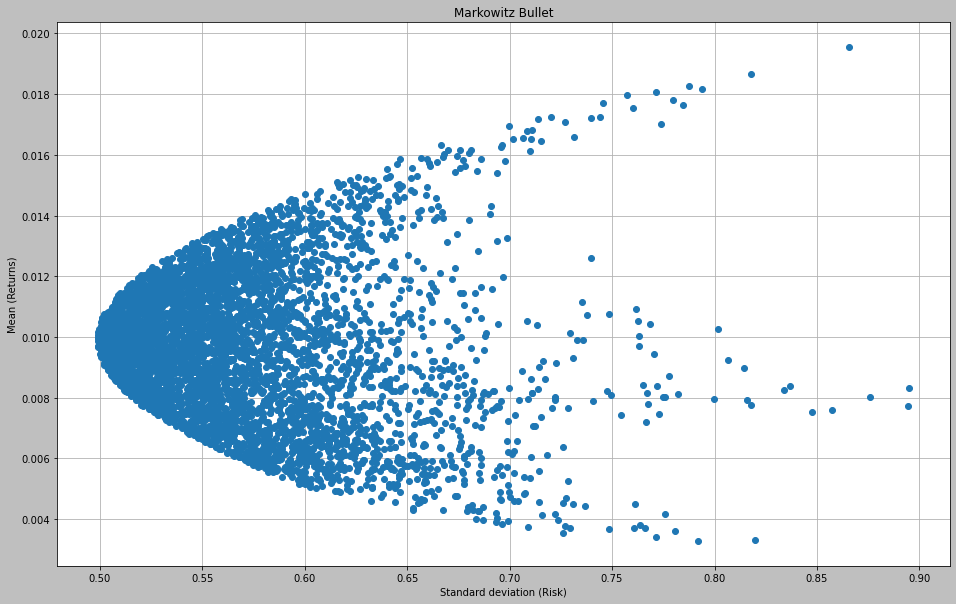

In [ ]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

def plot_portfolio(μ, Σ):
    """
    Creation of a markowitz bullet
    """ 
    n = len(Σ)
    PortfolioReturn = []
    PortfolioRisk = []
    for t in range(5000):
        w = np.random.rand(n)
        w /= np.sum(w)
        Risk = np.sqrt(np.dot(w.T, np.dot(Σ,w)))
        Return = np.dot(μ.T, w)
        PortfolioReturn.append(Return)
        PortfolioRisk.append(Risk)
    fig, ax = plt.subplots(figsize=(16,10), facecolor=(0.75, 0.75, 0.75))
    ax.plot(PortfolioRisk, PortfolioReturn, 'o', label='Portfolios')
    plt.xlabel('Standard deviation (Risk)')
    plt.ylabel('Mean (Returns)')
    plt.title('Markowitz Bullet')
    plt.grid()

#Number of assets
n_assets = 4

#Number of observatios (252 days = 1 year)
n_obs = 252*2

returns = np.random.randn(n_assets, n_obs) #Gerar n ativos com n retornos i.i.d.
means = returns.mean(axis=1)
risk = np.cov(returns)
plot_portfolio(means, risk)

Perceba que existe a possibilidade de otimizarmos os pesos em cada ativo pelo Risco x Retorno.

# Teoria - movimento Browniano geométrico

Um processo estocástico $\{S_t\}_{t \geq 0}$ pode ser modelado como um mBg (movimento Browniano geométrico) se satisfazer a  SDE:

$$dS_t = \mu S_t dt + \sigma S_t dB_t$$

Neste caso, a solução da SDE acima é dada por $S_t = S_0 e^{X(t)}$, onde $X(t) = \left(\mu - \frac{\sigma^2}{2} \right)t + \sigma B_t$ e $B_t$ é um movimento Browniano, ou seja, $X(t)$ é um movimento Browniano com drift $\left(\mu - \frac{\sigma^2}{2}\right)$.

## Propriedade

$\quad$ i. $\lim_{t \to +\infty} \mathbb{P}\left(S_t = +\infty \mid \mu - \frac{\sigma^2}{2} > 0\right) = 1$.


# Estratégia

O backtest abaixo tem a seguinte ideia, mensalmente, utilizando como universo os ativos que compoem o ibovespa no dia 20/10/2021, estimaremos os parâmetros do modelo movimento Browniano geométrico e iremos rankear os ativos do maior para o menor com base na seguinte fórmula:

$$\frac{\mu}{\sigma^2}$$

A ideia é que queremos os ativos com maior drift e menor volatilidade, e aproveitar-se da propriedade i citada anteriormente. Observe que $\mu$ e $\sigma$ são os parâmetros do modelo. Selecionaremos o top n ativos com maior ranking e aplicaremos a fronteira eficiente nesse conjunto, a estratégia fará o rebalanceamento dos ativos mensalmente. (Observe que a composição do ibovespa muda diariamente, então há um problema de look ahead bias)

C:\Users\bruno\anaconda3\lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


2021-06-01, Ending Value 1628201.92


                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2005-01-03  2005-01-03
End Period                 2021-06-01  2021-06-01
Risk-Free Rate             0.0%        0.0%
Time in Market             93.0%       100.0%

Cumulative Return          1,528.20%   389.64%
CAGR﹪                     18.52%      10.16%

Sharpe                     0.81        0.49
Smart Sharpe               0.79        0.48
Sortino                    1.11        0.7
Smart Sortino              1.08        0.68
Sortino/√2                 0.79        0.5
Smart Sortino/√2           0.76        0.48
Omega                      1.18        1.18

Max Drawdown               -60.09%     -59.96%
Longest DD Days            847         3400
Volatility (ann.)          25.27%      28.05%
R^2                        0.4         0.4
Calmar                     0.31        0.17
Skew                       -1.29       -0.16
Kurtosis                   16.29       8

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2008-05-21,2008-10-27,2010-09-15,847,-60.091708,-58.229038
2,2020-01-24,2020-03-18,2021-01-07,349,-46.714810,-42.393644
3,2007-07-20,2008-01-21,2008-04-22,277,-30.184745,-26.233955
4,2006-05-10,2006-09-22,2007-05-16,371,-26.359793,-24.962764
5,2011-06-06,2011-08-08,2012-03-02,270,-25.249078,-20.040186


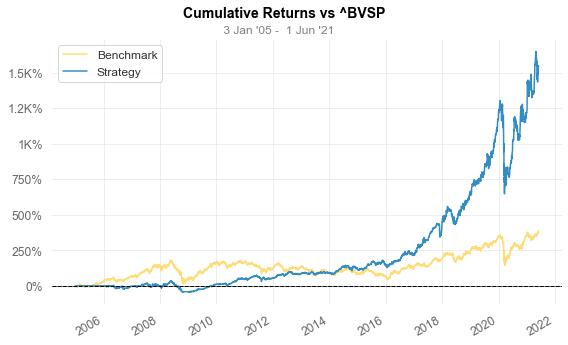

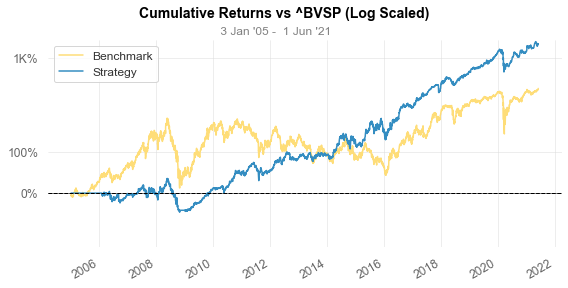

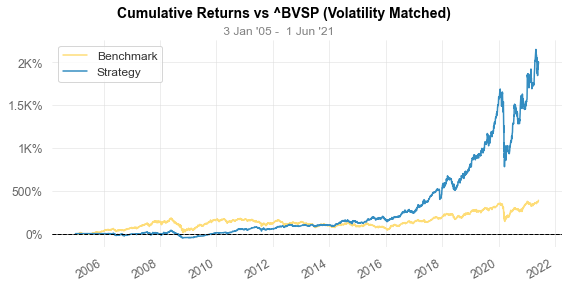

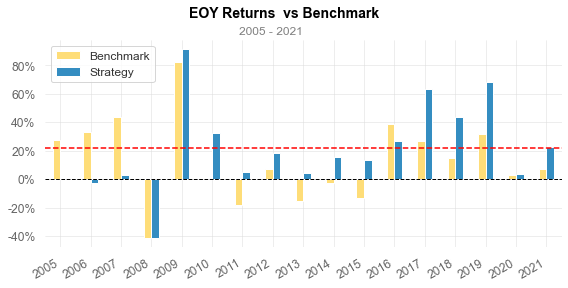

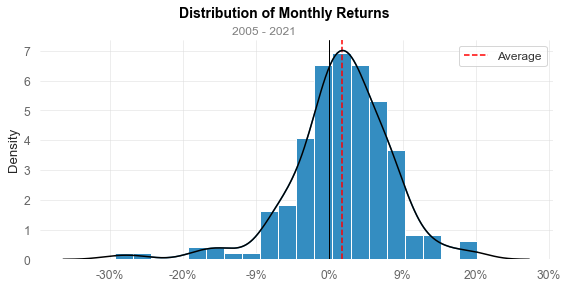

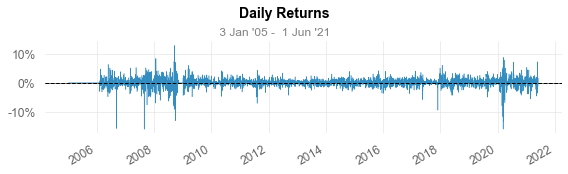

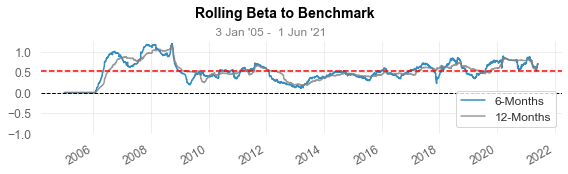

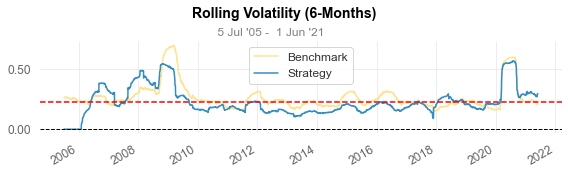

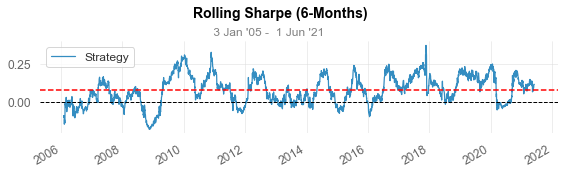

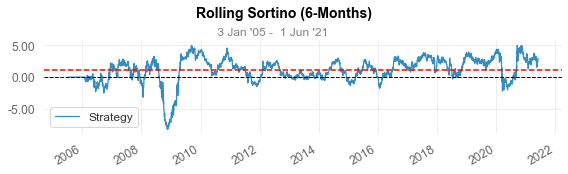

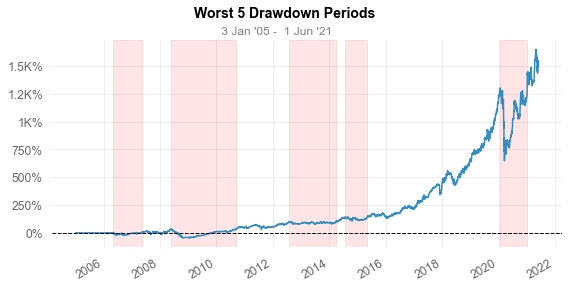

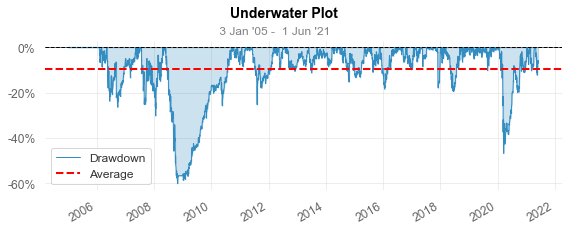

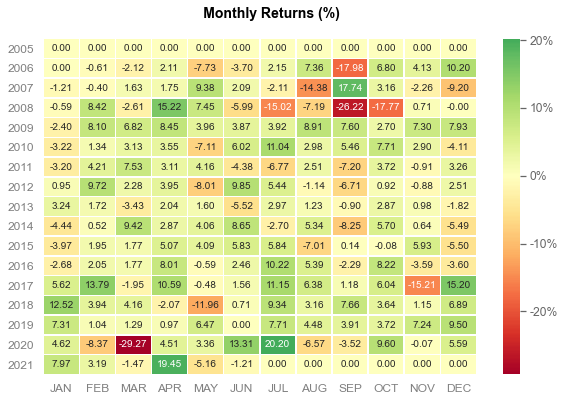

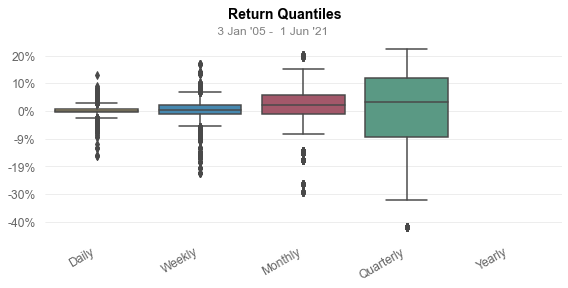

In [1]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)
from collections import OrderedDict

#library for filtering signals
import statsmodels.api as sm

#Numerical operations
import numpy as np
from numpy import log as ln
from math import floor, isnan

#Symbolic operations
import sympy as sy
from sympy import symbols, lambdify
from sympy.functions.elementary.exponential import exp

#Datetime operations
import datetime

#Import backtrader platform
import backtrader as bt
import backtrader.analyzers as btanalyzers

#Module to analyze portfolio
import pyfolio as pf

#Ploting library
import matplotlib.pyplot as plt

#operating system library
import os

#Optimizations
from scipy.optimize import minimize, Bounds, LinearConstraint
from scipy.stats import norm as N

#portfolio analyzer
import quantstats as qs

#data analysis library
import pandas as pd

#debugging library
from ipdb import set_trace

class Portfolio():
    """
        Class portfolio, retrieve optimal portfolio weights based on Markowitz efficient frontier model.

        Inputs:
            μ - assets log return vector
            Σ - assets variance-covariance matrix
            minimize_method - method to optimize (std = standard deviation, neg_sharpe = negative sharpe)
            long_only(True/False) - allows short position if False (not implemented)
    """

    def __init__(self, μ, Σ, premiumRisk=0, minimize_method='std', long_only=True):
        
        n = len(μ)
        
        self.n = n
        self.μ = μ
        self.Σ = Σ
        self.premiumRisk = 0
        self.n_days = 1
        self.minimize_method = minimize_method
        self.premiumRisk = premiumRisk
        self.set_long_only = long_only
    
    def n_bound(self,n):
        return [(0,None) for i in range(n)]
    
    def std(self, w, μ, Σ):
        return (np.dot(w.T, np.dot(Σ, w)))**0.5
    
    def neg_sharpe(self, w, μ, Σ):
        return -(np.dot(w.T,μ))/((np.dot(w.T, np.dot(Σ, w)))**0.5)
    
    
    def optimize(self):
        μ = self.μ
        Σ = self.Σ
        n = self.n
        if self.minimize_method=='std':
            f=self.std
        if self.minimize_method=='neg_sharpe':
            f=self.neg_sharpe
            
        #Initial Guess
        w = np.random.rand(n)
        w /= np.sum(w)
        
        #Model Constraints

        bounds = self.n_bound(n)
        constraints = LinearConstraint(np.ones(n), lb=1, ub=1)
        
        #Optimization
        optimization = minimize(f, w, args=(μ, Σ), 
                        method='SLSQP', 
                        bounds=bounds, constraints=constraints)

        #Risk, Return Calculations
        optW = optimization['x']
        optReturn = np.dot(optW.T,self.μ)
        optRisk = np.sqrt(np.dot(optW.T, np.dot(self.Σ, optW)))
        
        self.optRisk = optRisk
        self.optReturn = optReturn
        
        return optW, optRisk, optReturn
        
    
    def plot(self):
        #Creation of a markowitz graph representation
        n = self.n
        PortfolioReturn = []
        PortfolioRisk = []
        for t in range(10000):
            ω = np.random.rand(n)
            ω /= (np.sum(ω)*1)
            Return = np.dot(ω.T, self.μ)
            Risk = np.sqrt(np.dot(ω.T, np.dot(self.Σ, ω)))
            PortfolioReturn.append(Return)
            PortfolioRisk.append(Risk)
        fig, ax = plt.subplots(figsize=(16,10), facecolor=(0.75, 0.75, 0.75))
        
        #plot
        ax.plot(PortfolioRisk, PortfolioReturn, 'o', label='Portfolios')
        ax.plot(self.optRisk, self.optReturn, 'bo', label='Optimal Point')
        
        #aesthetics
        ax.set_facecolor((0.1, 0.1, 0.1))
        ax.grid(True)
        ax.set_ylabel('Expected Return')
        ax.set_xlabel('Standard Deviation')
        ax.legend()
        
        plt.show()

class gBm(bt.Indicator):
    """
        Geometric Brownian Motion model.
                dS_t = μ S_t dt + σ S_t dB_t
        
        Crescimento Exponencial. 
        o modelo tem um fit melhor para growth stocks como AAPL, TSLA, MGLU3, PRIO3 etc i.e.
        para ativos que tem um Crescimento Exponencial
    """
    lines = ('m', 'σ', 'μ', 'var', 'sl')
    params = dict(size=2**9+1, 
                  sl_quantil=0.1, 
                  sl_look_forward=5)
    
    def __init__(self):
        self.addminperiod(self.p.size)
        
    def next(self):
        self.S = self.data.close.get(0, size=self.p.size)
        self.estimateParams()
        

        self.lines.m[0] = self.m
        self.lines.σ[0] = self.σ
        self.lines.μ[0] = self.μ
        self.lines.var[0] = self.Var(self.p.sl_look_forward)
        self.lines.sl[0] = self.q(self.p.sl_quantil, self.p.sl_look_forward)
        

    
    def estimateParams(self):
        """
        Referência:
        "Estimation of Geometric Brownian Motion Parameters for Oil Price Analysis" C. Jakob et al.
        """
        S = self.S
        X = np.diff(np.log(S), n=1)
        m = X.mean() #mean
        σ = X.std() #standard deviation
        μ = m + ((σ**2)/2) #drift
        n = len(S)

        self.m = m
        self.σ = σ
        self.μ = μ
        self.n = n
    
    def E(self, t):
        """
        Referência:
        Ross, Sheldon M. (2014). "Variations on Brownian Motion".
        Introduction to Probability Models (11th ed.).
        """
        S = self.S
        S0 = S[-1]
        μ = self.μ
        return S0*np.exp(μ*t)
    
    def Var(self, t):
        """
        Referência:
        Ross, Sheldon M. (2014). "Variations on Brownian Motion". 
        Introduction to Probability Models (11th ed.).
        """
        S = self.S
        S0 = S[-1]
        μ = self.μ
        σ = self.σ
        return (S0**2)*np.exp(2*μ*t)*(np.exp((σ**2)*t) - 1)
    
    def q(self, p, t):
        """
         quantil de St/S0 o qual é definido como:
                q(p) = exp( (μ - σ**2/2)*t + σ*np.sqrt(t)*inv_Φ(p))
         p ∈ (0,1)
        """
        #assert p>0 and p<1
        #assert type(t)==int

        σ = self.σ
        μ = self.μ
        
        mean = (μ - (σ**2/2))*t
        var = σ**2*t
        return np.exp(mean +  np.sqrt(var)*N.ppf(p, 0, 1))

class momentumStrat(bt.Strategy):
    """
        strategy class
    """
    params = dict(gBmSize=2**8+1, #number of observations to use in backtest to estimate parameters
                  enableLog=False, #enable log of buy and sell of assets
                  exposure=1, #exposure to the market
                  rebal_monthday=1, #which day in month to do the rebalancing
                  stocks_holding=10) #Max number of stocks holding 
    
    def __init__(self):
        self.order = None #variable to track pending orders
        acoes = self.datas 
        
        #construct line objects of gBm data
        gBms = [gBm(d, size=self.p.gBmSize) for d in acoes]
        driftAcoes = [gBm.μ for gBm in gBms]
        volatAcoes = [gBm.σ for gBm in gBms]
        
        #construct a line object of ranks 
        self.rank = {d:drift/volat for d, drift, volat in zip(acoes, driftAcoes, volatAcoes)}
        
        self.driftAcoes = {d:drift for d, drift in zip(acoes, driftAcoes)}
        self.volatAcoes = {d:volat for d, volat in zip(acoes, volatAcoes)}
        
        #create a timer to execute the strategy montly
        self.add_timer(
            when=bt.Timer.SESSION_START,
            monthdays=[self.p.rebal_monthday],
            monthcarry=True  # if a day isn't there, execute on the next
        )
    
    def notify_order(self, order):
        '''Notify if an orde was executed/submited or not'''
    
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))
                
                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
                
            else:  # Sell
                
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)
        
        elif order.status==order.Canceled:
            self.log('Order Canceled. Price: {}'.format(order.price))
        elif order.status==order.Margin:
            self.log('Order Margin. Price: {}'.format(order.price))
        elif order.status==order.Rejected:
            self.log('Order Rejected. Price: {}'.format(order.price))

        self.order = None

    def log(self, txt, dt=None, doprint=False):
        '''Logging function fot this strategy'''
        if self.params.enableLog or doprint:
            dt = dt or self.datas[0].datetime.date(0)
            print('%s, %s' % (dt.isoformat(), txt))
    
    def getPortfolioParameters(self, datas:list):
        '''Get portfolio assets log returns vector and assets variance-covariance matrix'''
        S = np.column_stack(tuple(np.array(d).T for d in map(lambda x: x.close.get(0, self.p.gBmSize), datas)))
        S0 = S[0]
        X = np.diff(np.log(np.divide(S,S0)), n=1, axis=0)
        μ = X.mean(axis=0)
        Σ = np.cov(X, rowvar=False)
        
        n = len(datas)

        return μ, Σ
    
    def notify_timer(self, timer, when, *args, **kwargs):
        '''this function is called monthly, it is our strategy logic'''
        l = len(self)
        if l < self.p.gBmSize or self.order:
            return
        
        rank = {d:rank for (d, rank) in self.rank.items() if d.close.get(0, self.p.gBmSize)}

        ranks = sorted(
            rank.items(),  # get the (d, rank), pair
            key=lambda x: x[1][0],  # use rank (elem 1) and current time "0"
            reverse=True,  # highest ranked 1st ... please
        )
        

        top_ranks = ranks[:self.p.stocks_holding]
        datas = [data for (data, rank) in top_ranks]
        μ, Σ = self.getPortfolioParameters(datas)
        portfolio = Portfolio(μ, Σ, minimize_method='neg_sharpe')
        w, Risk, Return = portfolio.optimize()
        #portfolio.plot()
        
        opt_portfolio = [(data,weight) for (data,weight) in zip(datas,w)]
        current_positions = [d for d, pos in self.getpositions().items() if pos]
 
        
        
        #if we're not in market
        if len(current_positions)==0:
            for (d,weight) in opt_portfolio:
                if weight!=0:
                    self.order = self.order_target_percent(d, target=weight)
                    self.log('Buying: {} /---/ Rank: {:.4f} /---/ Weight: {:.3f}'.format(d._name, 
                                                                                   rank[d][0], 
                                                                                   weight))
            return
                
        
        #if we're in market
        else:
            
            # remove those no longer top ranked
            # do this first to issue sell orders and free cash
            for d in (d for d in current_positions if d not in datas):
                self.log('Closing: {} /---/ Rank: {:.4f}'.format(d._name, rank[d][0]))
                self.order_target_percent(d, target=0.0)
            
            # rebalance those already top ranked and still there
            for d in (d for d in current_positions if d in datas):
                i = datas.index(d)
                self.log('Rebalancing: {} /---/ Rank: {:.4f} /---/ Weight: {:.3f}'.format(d._name,
                                                                                     rank[d][0],
                                                                                     w[i]))
                self.order_target_percent(d, target=w[i])
                del datas[i]  # remove it, to simplify next iteration
                w = np.delete(w, i)
                
            # issue a target order for the newly top ranked stocks
            # do this last, as this will generate buy orders consuming cash
            for i,d in enumerate(datas):

                if w[i]!=0:
                    self.log('Buying: {} /---/ Rank: {:.4f} /---/ Weight: {:.3f}'.format(d._name,
                                                                                         rank[d][0],
                                                                                         w[i]))
                    self.order_target_percent(d, target=w[i])
                else:
                    continue

    def stop(self):
        self.log('Ending Value %.2f' %
                 (self.broker.getvalue()), doprint=True)
    
def runStrat(in_start, in_end, wf=False, best_set=None):
    '''create cerebro instance, set cash, add data, add strategy and run it'''
    cerebro = bt.Cerebro()
    
    #Set cash value
    cerebro.broker.set_cash(100000)
    
    #Set commission modelo
    cerebro.broker.setcommission(commission=0)
    
    cerebro.broker.set_checksubmit(False)
    
    
    data_font = 'data'
    
    #Adding data
    start=datetime.datetime.strptime(in_start, '%Y-%m-%d')
    end=datetime.datetime.strptime(in_end, '%Y-%m-%d')
    

    files = os.listdir(data_font)
    
    for file in files:
        #print(file)
        datapath='{}//'.format(data_font)+file
        data = bt.feeds.YahooFinanceCSVData(dataname=datapath,
                                            fromdate=start,
                                            todate=end,
                                            reverse=False)
        cerebro.adddata(data)
    
    
    
    #Add analyzers
    cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')
    cerebro.addanalyzer(btanalyzers.SharpeRatio, _name='sharpe')
    
    #Add Strategy    
    if wf:
        cerebro.addstrategy(momentumStrat, wf=wf)
    else:
        cerebro.addstrategy(momentumStrat)
    
    #Run Algo
    results = cerebro.run(maxcpus=1)

    
    #Plot results
    #cerebro.plot()
    
    return results

def analyzeStrat(results, live):
    '''analyze strategy results'''
    strat = results[0]
    pyfoliozer = strat.analyzers.getbyname('pyfolio')
    returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
    
    # extend pandas functionality with metrics, etc.
    qs.extend_pandas()
    returns.index = pd.to_datetime(returns.index.astype(str).str[:10])
    qs.reports.full(returns, '^BVSP')

if __name__=='__main__':
    live = '2021-01-01'
    r = runStrat('2005-01-03', '2021-06-02')
    analyzeStrat(r, live)